# Multivariable Regression and Bias

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.simplefilter("ignore")
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import patches
from datascience import *
%matplotlib inline
from sklearn.metrics import mean_squared_error
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

nlsy = Table.read_table('nlsy_cleaned_small.csv')
nlsy = nlsy.with_column("college", nlsy.column("college").astype(float))
nlsy = nlsy.with_column("AFQT", nlsy.column("AFQT").astype(float))

Our procedure earlier showed that we expect to see roughly a 70% increase in earnings in people who went to college vs. people who did not go to college. Does this imply that your decision to go to college was worthwhile, and now you can expect to have roughly 70% higher earnings compared to the version of you who did not go to college?

Let's go back to our discussion of experiments from earlier. In an ideal experiment, we would want a good sample of people who are about to graduate high school, and then randomly assign them to either a treatment group that gets sent to college, and a control group that does not. If you are in the treatment group you *must* go to college, and if you are in the control group you *cannot* go to college. Since the decision to go to college in this case is completely random, we can safely assume that the treatment and control groups are on average identical in attributes, apart from college attendance. We can therefore compare their log earnings in the future to see the effect of going to college.

Clearly this experiment is impossible to perform. We cannot randomly assign people to go to college. What's different between this ideal experiment and our regression from earlier? What's the issue with comparing the differences in log earnings for people in our sample who happened to go to college and those who did not?

In our sample, the treatment (went to college) and control (did not go to college) groups are not identical in every way except for college! People aren't randomly assigned college, they *choose* to go to college. The factors that cause someone to go to college are complex and lead to differences between people who chose to go to college and those who did not. When we perform regression on the variable `college`, since the groups in the sample are different, not only are we capturing the effect of going to college, but we are also capturing the effects of everything else that is different about the two groups that also affects earnings.

Imagine another variable that captures the wealth of your family. College can be very expensive, so it might be the case that the wealthier your family is, the more likely you are to go to college. Also, it's easy to imagine that the wealthier your family is, the wealthier you are likely to be in the future. This implies that the group of people in the sample who went to college will tend to be wealthier than the group that did not. Also, the group of people who went to college is expected to earn more not necessarily because they went to college, but simply because they are wealthier.

Therefore, when we do regression to measure the differences in earnings between people who went to college and those who did not, we also capture differences in earnings between people who grew up wealthier and those who did not. Because of this, we *over-estimate* the effect of going to college. $\hat{\beta}$ captures the average observed benefit of going to college *and* being wealthier, but we're only interested in college. This is called *omitted variable bias*. Family wealth is an omitted variable in this regression and it's causing our results to be biased.

Let's think of another example of omitted variable bias. In the NLSY dataset, there is a variable called `AFQT`. AFQT is a score on a particular standardized test that all people in the sample took. Let's use AFQT as a proxy measurement for the abstract idea of academic capability. While a standardized test is by no means the sole indication of someone's ability or intelligence, let's ignore that very complicated issue for now and assume that AFQT does an O.K. job at capturing this ability variable that is otherwise very difficult to measure.

Is there omitted variable bias from AFQT? Almost certainly. It seems fair to believe that people who choose to go to college are on average more academically-capable, and it also seems fair to say that on average we expect more capable people to earn more. Therefore, $\hat{\beta}$ above might be capturing the effects of being more capable, along with the effects of going to college.

How can we fix this issue? Multivariable regression.

## Multivariable Regression

So far we have only been regressing outcome variable $y$ onto one explanatory variable $x$. To find the regression line, we choose $\hat{\alpha}$ and $\hat{\beta}$ that minimize the mean squared error. But what if we believe that $y$ is actually determined by two variables, $x_1$ and $x_2$? Specifically, what if the "true" model is

$$
y = \alpha + \beta_1 x_{1} + \beta_2 x_{2} + \epsilon
$$

and we would like to estimate

$$
\hat{y} = \hat{\alpha} + \hat{\beta}_1 x_{1} + \hat{\beta}_2 x_{2}
$$

Now our challenge is choosing $\hat{\alpha}$, $\hat{\beta}_1$, *and* $\hat{\beta}_2$ that minimize the mean squared error. To this end, we will use the `minimize` function to minimize a function `to_minimize` that takes in model parameters and returns the model's RMSE.

In [3]:
def rmse(target, pred):
    return np.sqrt(mean_squared_error(target, pred)) 

def to_minimize(intercept, beta_1, beta_2):
    predictions = intercept + beta_1 * nlsy.column('college') + beta_2 * nlsy.column("AFQT")
    actual = nlsy.column('log_earn_1999')
    return rmse(predictions, actual)

minimize(to_minimize)

array([  9.95595982e+00,   4.30179178e-01,   8.37569589e-03])

We see that `minimize` return an $\hat{\alpha}$ of 9.956, a $\hat{\beta}_1$ of 0.430, and a $\hat{\beta}_2$ of 0.008. Let's perform the regression using `statsmodels` and see what we get.

In [4]:
y = nlsy.select('log_earn_1999').values
X = nlsy.select('college', 'AFQT').values

model = sm.OLS(y, sm.add_constant(X)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     388.5
Date:                Thu, 18 Jan 2024   Prob (F-statistic):          2.12e-158
Time:                        13:38:46   Log-Likelihood:                -7421.0
No. Observations:                5413   AIC:                         1.485e+04
Df Residuals:                    5410   BIC:                         1.487e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9563      0.025    401.520      0.000       9.908      10.005
x1             0.4301      0.037     11.731      0.000       0.358       0.502
x2             0.0084      0.001     16.083      0.000       0.007       0.009
==============================================================================
Omnibus:                     2898.806   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34192.355
Skew:                          -2.307   Prob(JB):                         0.00
Kurtosis:                      14.415   Cond. No.                         155.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here $\hat{\beta}_1$ is 0.43, compared to 0.72 from the earlier biased (single variable) regression. That's huge! This implies that when we control for a person's ability (i.e. we get rid of that source of bias), we only see that on average going to college is associated with a 43% increase in earnings instead of 72%. Furthermore, looking at the 95% confidence interval for $\hat{\beta}_2$, we see that it does not contain 0, which would imply that AFQT score has a strong non-zero association with earnings.

These observations validate our claim that AFQT was probably an omitted variable causing $\hat{\beta}_1$ to be biased. When interpreting $\hat{\beta}$ coefficients, you should always be mindful of potential sources of bias that could make your coefficients misleading and not useful from an econometric context.

**Note:** A linear regression model makes predictions for $y$ which we've been calling $\hat{y}$. If you imagine that you are the model and are tasked with predicting people's earnings, you will almost certainly want more than just their years of schooling to make an accurate prediction. The more relevant variables you are given, the better predictions you are likely to make compared to just using one variable. The Variable needs to be relevant though; the day of the week a person was born on is probably not useful in predicting earnings. This is just another way of thinking about the usefulness of multivariable regression.

### Visualizing Multivariable Regression

The 3D plots below show us our variables of interest and the regression plane from two different angles.

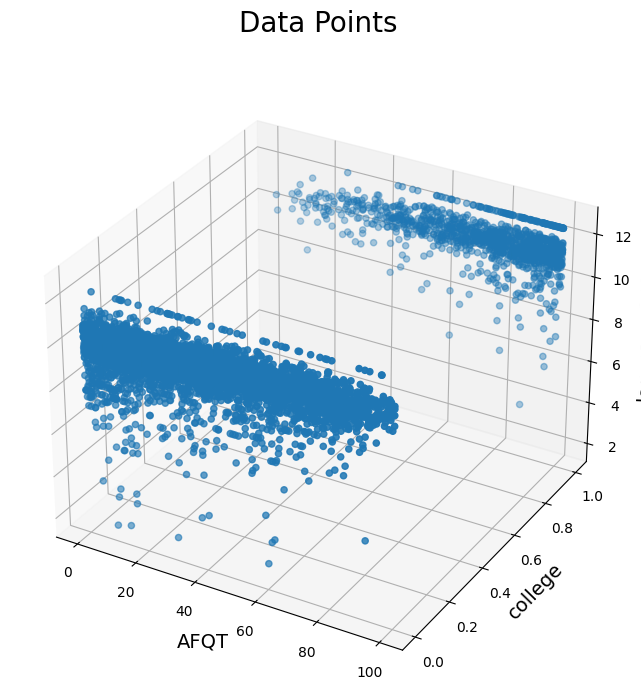

In [5]:
ax = plt.figure(figsize=(8,8)).add_subplot(111, projection='3d')
ax.scatter(nlsy.column("AFQT"), 
           nlsy.column("college"), 
           nlsy.column('log_earn_1999'))
plt.xlabel("AFQT", fontsize=14)
plt.ylabel("college", fontsize=14)
ax.set_zlabel("log_earn_1999", fontsize=14)
plt.title("Data Points", pad=30, size=20);

Scatter plot in 3D showing data points related to AFQT, college, and log_earn_1999.

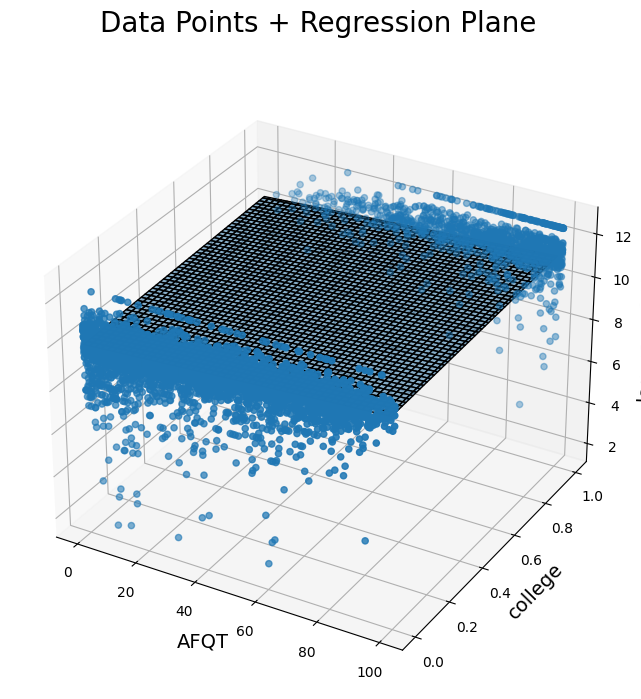

In [6]:
X,Y = np.meshgrid(np.arange(0,100,1), np.arange(0,1,0.01))
Z = 0.0084 * X + 0.4301 * Y + 9.9563
ax = plt.figure(figsize=(8,8)).add_subplot(111, projection='3d')
ax.scatter(nlsy.column("AFQT"), 
           nlsy.column("college"), 
           nlsy.column('log_earn_1999'))
ax.plot_surface(X, Y, Z, alpha=0.5)
plt.xlabel("AFQT", fontsize=14)
plt.ylabel("college", fontsize=14)
ax.set_zlabel("log_earn_1999", fontsize=14)
plt.title("Data Points + Regression Plane", pad=30, size=20);

Scatter plot in 3D with a visible regression plane. Data points are related to AFQT, college, and log_earn_1999. Regression plane represented by a surface.

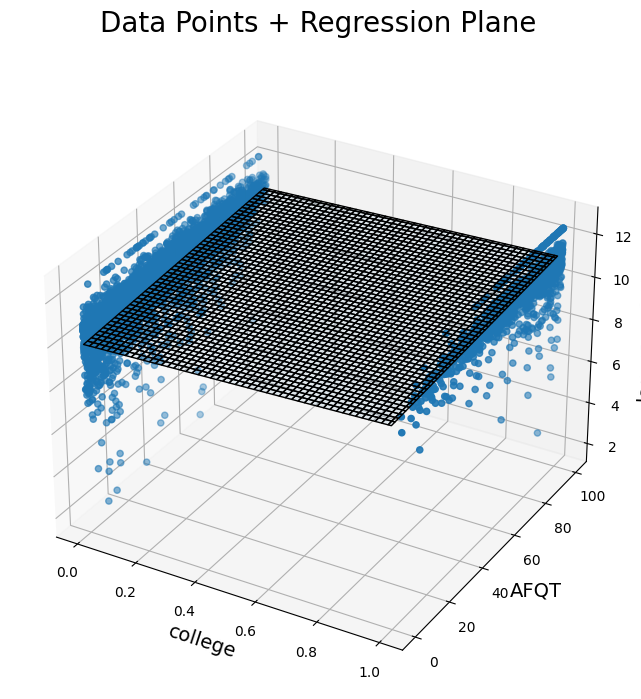

In [7]:
X,Y = np.meshgrid(np.arange(0,1,0.01), np.arange(0,100,1))
Z = 0.4301 * X + 0.0084 * Y + 9.9563
ax = plt.figure(figsize=(8,8)).add_subplot(111, projection='3d')
ax.scatter(nlsy.column("college"), 
           nlsy.column("AFQT"), 
           nlsy.column('log_earn_1999'))
ax.plot_surface(X, Y, Z, alpha=0.1)
plt.ylabel("AFQT", fontsize=14)
plt.xlabel("college", fontsize=14)
ax.set_zlabel("log_earn_1999", fontsize=14)
plt.title("Data Points + Regression Plane", pad=30, size=20);

Scatter plot in 3D with a rotated view of data points related to college, AFQT, and log_earn_1999. Regression plane represented by a semi-transparent surface.

The regression plane, instead of the regression line, represents the values for log earnings that the regression model would predict for any given college and AFQT input. It's a plane now because there are two possible inputs, as opposed to one.

## Colinearity and Dummy Variables

When we do regression onto the variable `college`, why don't we also include a variable that measures not going to college? In other words, why don't we regress on college and the opposite of college so that way we can get an estimate of the average earnings of college-goers and non-college-goers. Why do we do this roundabout way of using the intercept term and a difference in means?

Imagine we have a dataset with a variable for college, a variable for not going to college, and the intercept term. The issue with this is that there is now redundant information.

Let's look at just one element of the sample. Let's say this person went to college, so this person's features are the following:
* College = 1
* Not College = 0
* Intercept term = 1

Clearly there is a redundancy here; you can guess one of the variables from the others. More specifically, by redundancy we mean that *one variable can be written as a linear combination of the other variables*. In fact, there are three different combinations:
* Intercept = College + Not College
* Not College = Intercept - College
* College = Intercept - Not College

These equalities aren't just true for this one person; they actually hold true for any possible person in the sample. This is because of the way we defined "college" and "not college". You can't simultaneously be in both, and so adding them together you get 1, which is just the intercept term.

In general, we have redundancy whenever we have *mutually exclusive* and *exhaustive* dummy variables in combination with an intercept term.
* Mutually exclusive: You cannot be in more than one dummy variable.
* Exhaustive: You must be in at least one dummy variable.

You can see that "college" and "not college" satisfy these conditions. So why is this redundancy an issue? It becomes ambiguous what the values for $\hat{\alpha}$, $\hat{\beta}_1$, and $\hat{\beta}_2$ should be in the model where we include all three terms:

$$
\text{log earnings} = \hat{\alpha} + \hat{\beta}_1 \text{college} + \hat{\beta}_2 \text{not college}
$$

Consider a case where we expect people who went to college to have log earnings of 10 and those who did not go to college to have log earnings of 8. What values for $\hat{\beta}$ and $\hat{\alpha}$ make sense?

* $\hat{\beta}_1 = 10$
* $\hat{\beta}_2 = 8$
* $\hat{\alpha} = 0$

make sense. These are valid values for $\hat{\beta}$ and $\hat{\alpha}$ that satisfy the condition above. To see why, consider a person with college:

$$\begin{aligned}
\text{log earnings} &= \hat{\alpha} + \hat{\beta}_1 \cdot 1 + \hat{\beta}_2 \cdot 0 \\
\text{log earnings} &= \hat{\alpha} + \hat{\beta}_1 \\
\text{log earnings} &= 0 + 10 = 10
\end{aligned}$$

and a person without college:

$$\begin{aligned}
\text{log earnings} &= \hat{\alpha} + \hat{\beta}_1 \cdot 0 + \hat{\beta}_2 \cdot 1 \\
\text{log earnings} &= \hat{\alpha} + \hat{\beta}_2 \\
\text{log earnings} &= 0 + 8 = 8
\end{aligned}$$

* $\hat{\beta}_1 = 2$
* $\hat{\beta}_2 = 0$
* $\hat{\alpha} = 8$

also make sense. To see why, consider a person with college:

$$\begin{aligned}
\text{log earnings} &= \hat{\alpha} + \hat{\beta}_1 \cdot 1 + \hat{\beta}_2 \cdot 0 \\
\text{log earnings} &= \hat{\alpha} + \hat{\beta}_1 \\
\text{log earnings} &= 8 + 2 = 10
\end{aligned}$$

and a person without college:

$$\begin{aligned}
\text{log earnings} &= \hat{\alpha} + \hat{\beta}_1 \cdot 0 + \hat{\beta}_2 \cdot 1 \\
\text{log earnings} &= \hat{\alpha} + \hat{\beta}_2 \\
\text{log earnings} &= 8 + 0 = 8
\end{aligned}$$

It turns out, there are actually infinitely many solutions for $\hat{\beta}$ that satisfy the condition where people who went to college have mean log earnings of 10 and people who did not go to college have mean log earnings of 8. This holds true for all situations where you regress on a constant and a set of mutually exclusive and exhaustive dummies. There is no unique solution for $\hat{\beta}$, which is a problem for econometricians who want unique and interpretable coefficients.

In fact, there is mathematical justification for this as well. At some point in the math involved in performing regression, having redundant variables causes a division by 0. This is particularly upsetting for your computer, and it will complain.

So how do we avoid this problem? We deliberately exclude one of the variables. It can technically either be one of the dummy variables or the intercept term, but we usually really want to have an intercept term present in our regression for other reasons. So we usually get rid of one of the dummy variables. Notice that we implicitly did this earlier. We did not include "not college" in our first regression.